# Code

In [255]:
import numpy as np
import random
import matplotlib.pyplot as plt

class Agent:
    def __init__(self, num_states, num_actions, temperature, lr, endowment, MPCR, incentive):
        actions = np.linspace(0, endowment, num=num_actions)
        self.Q = np.array([[endowment - action + MPCR * action + (incentive if action > 0 else 0) 
                            for action in actions] for _ in range(num_states)])
        self.temperature = temperature  
        self.num_actions = num_actions
        self.lr = lr
        self.num_states = num_states
        self.state_counts = np.ones(num_states)
        self.state_frequencies = self.state_counts / np.sum(self.state_counts)
    
    def update_state_counts(self, observed_state):
        self.state_counts[observed_state] += 1
        self.state_frequencies = self.state_counts / np.sum(self.state_counts)
    
    def predict_state(self):
        predicted_state = np.random.choice(self.num_states, p=self.state_frequencies)
        return predicted_state
    
    def softmax(self, q_values):
        if self.temperature > 0:
            max_q = np.max(q_values)
            exp_q = np.exp((q_values - max_q) / self.temperature)
            probabilities = exp_q / np.sum(exp_q)
        else:
            probabilities = np.zeros_like(q_values)
            probabilities[np.argmax(q_values)] = 1.0
        return probabilities

    def choose_action(self, use_most_likely_state=False):
        if use_most_likely_state:
            predicted_state = np.argmax(self.state_frequencies)
        else:
            predicted_state = self.predict_state()
        q_values = self.Q[predicted_state]
        probabilities = self.softmax(q_values)
        action = np.random.choice(len(q_values), p=probabilities)
        return action, predicted_state
    
    def update_Q(self, state, action, reward):
        self.Q[state][action] = self.lr * reward + (1 - self.lr) * self.Q[state][action]


def discretize_total_contribution(total_contribution, num_states, N, E):
    max_total = N * E
    state = int(round((total_contribution / max_total) * (num_states - 1)))
    state = min(state, num_states - 1)
    return state


class Environment:
    def __init__(self, N, E, MR, num_rounds, temperature=10, lr=0.5, num_states=11, num_actions=11, incentive=0):
        self.N = N                  
        self.E = E                 
        self.MR = MR            
        self.num_rounds = num_rounds
        self.initial_temperature = temperature
        self.lr = lr
        self.num_states = num_states
        self.num_actions = num_actions
        self.incentive = incentive 
        self.agents = [Agent(num_states=self.num_states, num_actions=self.num_actions, temperature=self.initial_temperature, lr=self.lr, endowment=self.E, MPCR=self.MR/self.N, incentive=self.incentive) for _ in range(N)]
        self.action_values = np.linspace(0, self.E, num=self.num_actions)
    
    def run_simulation(self, plot=True):
        total_contributions_over_time = []
        prev_total_contribution = 0
        prev_state = discretize_total_contribution(prev_total_contribution, self.num_states, self.N, self.E)

        for round_num in range(self.num_rounds):
            contributions = []
            actions = []
            predicted_states = []

            for agent in self.agents:
                action, predicted_state = agent.choose_action()
                contribution = self.action_values[action]
                contributions.append(contribution)
                actions.append(action)
                predicted_states.append(predicted_state)

            total_contribution = sum(contributions)
            total_contributions_over_time.append(total_contribution)

            payoff_per_agent = (self.MR * total_contribution) / self.N
            payoffs = [(self.E - contrib + payoff_per_agent + (self.incentive if contrib > 0 else 0)) for contrib in contributions]

            prev_state = discretize_total_contribution(total_contribution, self.num_states, self.N, self.E)

            for i, agent in enumerate(self.agents):
                reward = payoffs[i]
                agent.update_Q(predicted_states[i], actions[i], reward)
                agent.update_state_counts(prev_state)

        final_contributions = []
        final_rounds = 1
        for agent in self.agents:
            agent.temperature = 0 

        for round_num in range(final_rounds):
            contributions = []
            actions = []
            predicted_states = []

            for agent in self.agents:
                action, predicted_state = agent.choose_action(use_most_likely_state=True)
                contribution = self.action_values[action]
                contributions.append(contribution)
                actions.append(action)
                predicted_states.append(predicted_state)

            total_contribution = sum(contributions)
            total_contributions_over_time.append(total_contribution)
            final_contributions.append(total_contribution)

            payoff_per_agent = (self.MR * total_contribution) / self.N
            payoffs = [(self.E - contrib + payoff_per_agent) for contrib in contributions]

            prev_state = discretize_total_contribution(total_contribution, self.num_states, self.N, self.E)

            for i, agent in enumerate(self.agents):
                reward = payoffs[i]
                agent.update_Q(predicted_states[i], actions[i], reward)
                agent.update_state_counts(prev_state)

        average_final_contribution = np.mean(final_contributions)
        self.result = average_final_contribution
        self.record = total_contributions_over_time
        
        if plot:
            plt.figure(figsize=(10, 6))
            plt.plot(range(1, self.num_rounds + final_rounds + 1), total_contributions_over_time, marker='o')
            plt.ylim(0, self.N * self.E)
            plt.title('Total Contribution Over Time')
            plt.xlabel('Round')
            plt.ylabel('Total Contribution')
            plt.grid(True)
            plt.show()

            print(f"Average rational contribution after learning: {average_final_contribution}")
        
    def plot_average_Q_table(self):
        average_Q = np.mean([agent.Q for agent in self.agents], axis=0)

        fig, ax = plt.subplots()
        cax = ax.matshow(average_Q, cmap='inferno') 
        fig.colorbar(cax)

        ax.set_xticks(np.arange(self.num_actions))
        ax.set_yticks(np.arange(self.num_states))

        ax.set_xticklabels([f"{100 * val/self.E:.0f}%" for val in self.action_values])
        ax.set_yticklabels([f"{100 * idx/(self.num_states-1):.0f}%" for idx in range(self.num_states)])

        plt.xlabel("Agent's Contribution (% of Possible Contribution)")
        plt.ylabel("Total Contribution (% of Possible Total Contribution)")
        plt.title("Average Q-Table Visualization")
        plt.show()
        
    def plot_average_expected_Q_table(self):
        state_probabilities = self.agents[0].state_frequencies

        average_Q = np.mean([agent.Q for agent in self.agents], axis=0)

        expected_Q = average_Q * state_probabilities[:, np.newaxis]

        fig, ax = plt.subplots()
        cax = ax.matshow(expected_Q, cmap='inferno')  # Changed to 'inferno' which was previously used
        fig.colorbar(cax)

        ax.set_xticks(np.arange(self.num_actions))
        ax.set_yticks(np.arange(self.num_states))

        ax.set_xticklabels([f"{100 * val/self.E:.0f}%" for val in self.action_values])
        ax.set_yticklabels([f"{100 * idx/(self.num_states-1):.0f}%" for idx in range(self.num_states)])

        plt.xlabel("Agent's Contribution (% of Possible Contribution)")
        plt.ylabel("Total Contribution (% of Possible Total Contribution)")
        plt.title("Expected Value Q-Table Visualization")
        plt.show()

# Sample Run
### thinking of just allowing users to control incentives

incentive level (endowment level is 100): 100


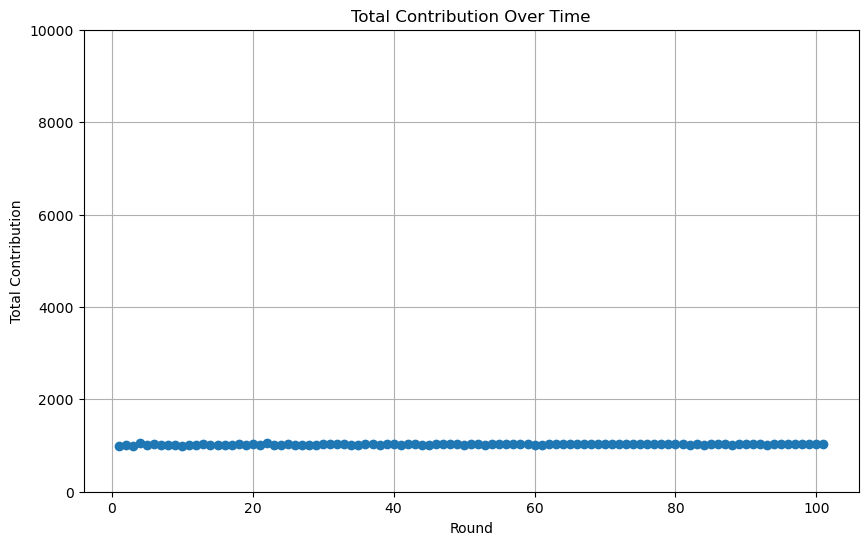

Average rational contribution after learning: 1030.0


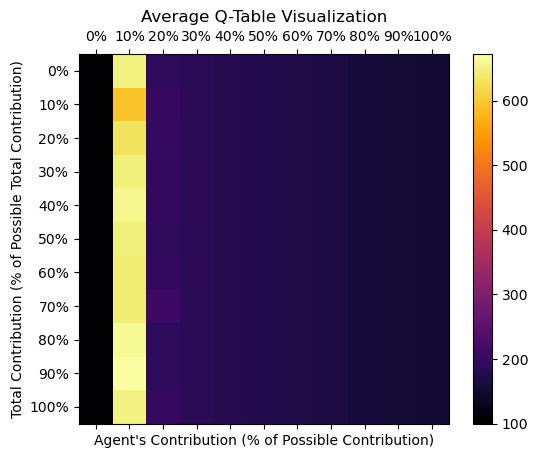

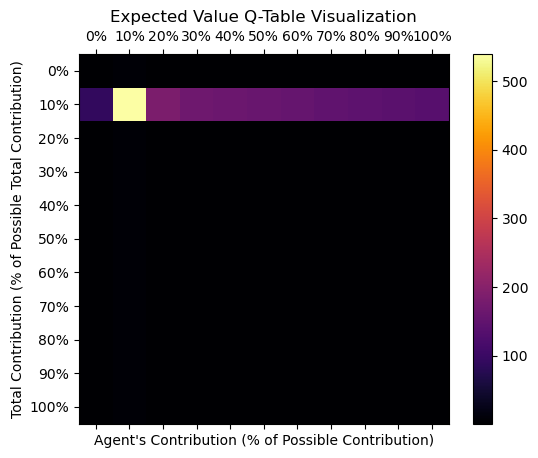

In [270]:
N = 100               
E = 100 
MR = 50
num_rounds = 100
temperature = 1
lr = 1
incentive = float(input(f"incentive level (endowment level is {E}): "))

env = Environment(N=N, E=E, MR=MR, num_rounds=num_rounds, temperature=temperature, lr=lr, incentive=incentive)
env.run_simulation()
env.plot_average_Q_table()
env.plot_average_expected_Q_table()

# Experiment for Validation
### In the case of no incentives, marginal per capita return (MPCR) of 1 should be the threshold for contribution decision.

In [268]:
results = dict()
MRs = [i for i in range(0,201)]
for i in range(10):
    for MR in MRs:
        N = 100               
        E = 100 
        num_rounds = 100
        temperature = 1
        lr = 1
        incentive = 0

        env = Environment(N=N, 
                          E=E, 
                          MR=MR, 
                          num_rounds=num_rounds, 
                          temperature=temperature, 
                          lr=lr, 
                          incentive=incentive)
        env.run_simulation(plot=False)
        
        if MR not in results.keys():
            results[MR] = []
            results[MR].append(env.result)
        else:
            results[MR].append(env.result)
        
        #print(i, MR)
        

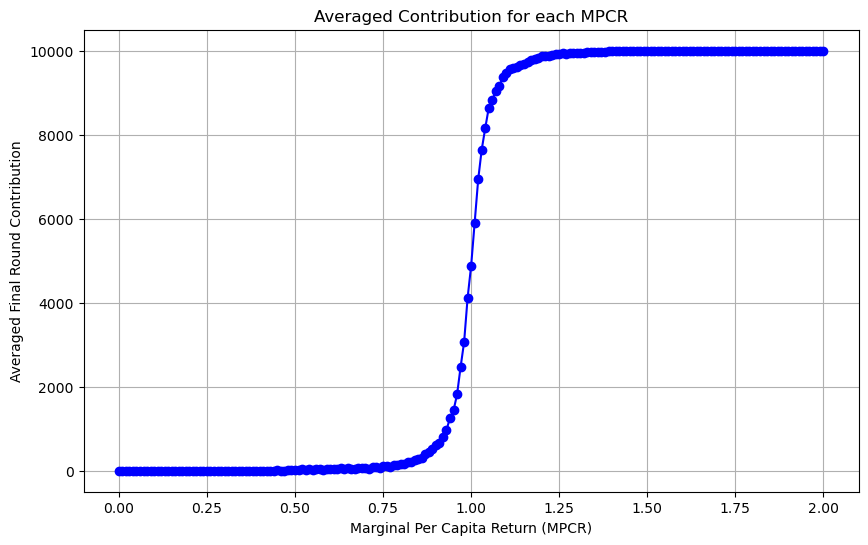

In [269]:
def plot_averaged_contributions(results, N):
    # Prepare lists for plotting
    MPCR_values = np.array(list(results.keys()))/N
    average_contributions = [sum(contributions) / len(contributions) if contributions else 0 for contributions in results.values()]

    plt.figure(figsize=(10, 6))
    plt.plot(MPCR_values, average_contributions, marker='o', linestyle='-', color='b')
    plt.title('Averaged Contribution for each MPCR')
    plt.xlabel('Marginal Per Capita Return (MPCR)')
    plt.ylabel('Averaged Final Round Contribution')
    plt.grid(True)
    plt.show()

plot_averaged_contributions(results, N)